In [1]:
import numpy as np
import matplotlib.pyplot as plt

Ks = [2,3,4,6,10,20]

def vander(X, K):
    if K<0:
        raise Exception
    phi = np.zeros((len(X), K))
    for i in range(K):
        phi[:, i] = X**i
    return phi

def splitDataset(X,  Y, Ntrain:int):
    idx = np.arange(Y.shape[0])

    train_idx = idx[idx%2==0]
    test_idx = idx[idx%2==1]
    
    Xtrain = X[train_idx]
    Xtest = X[test_idx]
    Ytrain = Y[train_idx]
    Ytest = Y[test_idx]
    return (Xtrain, Ytrain), (Xtest, Ytest)

def computeError(theta, TE):
    X_test, Y_test =  TE
    f_x = vander(X_test, theta.shape[0]) @ theta
    return (np.linalg.norm(f_x - Y_test, 2)**2) / Y_test.shape[0]

In [2]:
def GD(grad_f, x0, kmax:int, tolf:float, tolx:float):
    # As output we want:
    # x -> The stationary point
    # k an integer, the number of iteration to the convergence
    # f_val -> A vector containing the values of f during the iterations
    # err_val -> A vector containing the values of || grad_f(x_k) || for any k
    
    alpha = 0.005
    allx = [x0]
    grads = [grad_f(x0)]
    err_val = [np.linalg.norm(grad_f((x0)))]
    k = 0

    first = True

    while k<kmax and \
        np.linalg.norm(grad_f((x0))) >= tolf*np.linalg.norm(grad_f((allx[0]))) and \
            (first or np.linalg.norm(x0 - allx[-1]) >= tolx*np.linalg.norm(allx[0])):

        first = False
        
        # Updare x
        x = x0 - alpha*grad_f((x0))
        
        # save the values
        allx.append(x)
        err_val.append(np.linalg.norm(grad_f((x))))
        grads.append(grad_f((x)))

        # Update k 
        k += 1
        
        # restart
        x0 = x

        #print(x0, allx[-1],grad_f((x0)), "\n",np.linalg.norm(x0 - allx[-1]), tolx*np.linalg.norm(allx[0]))

    return allx, k, grads, err_val

In [3]:
def SGD(grad_f, w0, D, batch_size, n_epochs):
    # As output we want:
    # x -> The stationary point
    alpha = 0.01
    
    # D is a dataset
    # D = (X,Y) where X is d x N and Y is N
    X, Y = D # Split D into X and Y
    #print(X.shape, Y.shape)
    
    d, N = X.shape

    n_batch_per_epoch = int(N / batch_size) 
    rest = N % batch_size
    if rest != 0:
        n_batch_per_epoch += 1

    X_backup = X
    Y_backup = Y

    # print("X_backup: ", X_backup.shape)
    # print("Y_backup: ", Y_backup.shape)

    # print ("n_batch_per_epoch: ", n_batch_per_epoch)
    # print("rest: ", rest)

    allW = [w0]
    #f_val = [f(w0, D)]
    grads = [grad_f(w0)]
    errs = [np.linalg.norm(grad_f(w0), 2)]

    ite=0

    # Start the iterations
    for epoch in range(n_epochs):
        #if epoch%5 == 0 :
            #print("epoch: ", epoch)
        # shuffle
        idx = np.arange(N)
        idx = idx.astype(int)
        np.random.shuffle(idx)

        X = X[:, idx]
        Y = Y[idx]        

        for k in range(n_batch_per_epoch):
            # Sample m from D
            # Mx <- X # Has shape d x batch_size
            # My <- Y # Has shape batch_size

            #print("Xshape: ", X.shape)
            my_batch_size = min(batch_size, X.shape[1])

            Mx = X[:, :my_batch_size]
            My = Y[:my_batch_size]
            M = (Mx, My)

            # remove Mx and My from x and y
            X = X[:, my_batch_size:]# np.delete(X, np.s_[:, 0:my_batch_size])
            Y = Y[my_batch_size:] #np.delete(Y, np.s_[0:my_batch_size])

            # update x 
            grad = np.reshape(grad_f(w0), w0.shape)
            w = w0 - alpha * grad

            # restart
            w0 = w
            allW.append(w0)

            errs.append(np.linalg.norm(grad_f(w0), 2))
            ite+=1
         
        # reload X and Y
        X = X_backup
        Y = Y_backup
        
        #f_val.append(f(w0, D))
        grads.append(grad_f(w0))
        

        ## ATTENTION: You have to shuffle again (differently)

    return allW, grads, errs, ite


In [4]:
dataset = {}
def createDataset(N,K):
    global dataset
    a = 0
    b = 1
    var=0.5

    theta_true = np.ones((K,))
    X = np.linspace(a,b,N)

    Phi = vander(X, K)
    Y = Phi @ theta_true
    Y = Y + np.random.normal(0, var, Y.shape)

    (X_train, Y_train), (X_test, Y_test) = splitDataset(X, Y, N/2)

    dataset[(N, K)] = [X, Y, theta_true, Phi, X_train, Y_train, X_test, Y_test]

createDataset(50,3)
createDataset(50,6)


In [5]:
def callGD(D, K, type, lmbda=None):
    X, Y = D
    theta = np.zeros((K,))

    Phi = vander(X, K)
    PhiT = Phi.T

    if type=='MLE':
        def grad(theta):
            return PhiT @ (Phi @ theta - Y)
    else:
        def grad(theta):
            return PhiT @ (Phi @ theta - Y) + lmbda*theta

    kmax = 10000
    tolf = 10e-8
    tolx = 10e-8
    allx, k, grads, err_val = GD(grad, theta, kmax, tolf, tolx)
    return allx[-1]

def callSGD(D, K, type, lmbda=None):
    X, Y = D
    theta = np.zeros((K,))
    Phi = vander(X, K)
    PhiT = Phi.T

    if type=='MLE':
        def grad(theta):
            return PhiT @ (Phi @ theta - Y)
    else:
        def grad(theta):
            return PhiT @ (Phi @ theta - Y) + lmbda*theta

    allW, grads, errs, ite = SGD(grad, theta, (Phi, Y), 4, 10)
    return allW[-1]

In [6]:
def plotMLE(X_train, Y_train, X_test, Y_test, K, i, true_sol, plot=None):
    Phi2 = vander(X_train, K)
    D = (X_train, Y_train)
    theta_mle_trial = callGD(D, K, 'MLE')
    theta_mle_trial3 = callSGD(D, K, 'MLE')
    theta_mle_trial2 = np.linalg.solve(Phi2.T @ Phi2, Phi2.T @ Y_train)
    f_x_trail = Phi2 @ theta_mle_trial
    f_x_trail2 = Phi2 @ theta_mle_trial2
    f_x_trail3 = Phi2 @ theta_mle_trial3

    if plot is not None:
        plt.subplot(3,3,i)
        plt.plot(X_train, Y_train, 'ro')
        plt.plot(X_test, Y_test, 'o')
        plt.plot(X_train, f_x_trail)
        plt.plot(X_train, f_x_trail3)
        plt.plot(X_train, f_x_trail2)
        plt.legend(['train set', 'test set', 'GD', 'SGD', 'Normal'])
        plt.grid()
   

    return computeError(theta_mle_trial, (X_train, Y_train)), computeError(theta_mle_trial, (X_test, Y_test)),\
        computeError(theta_mle_trial2, (X_train, Y_train)), computeError(theta_mle_trial2, (X_test, Y_test)),\
            computeError(true_sol, (X_train, Y_train)), computeError(true_sol, (X_test, Y_test)),\
                computeError(theta_mle_trial3, (X_train, Y_train)), computeError(theta_mle_trial3, (X_test, Y_test)),



def execMLE(K, N, plot=None):
    data = dataset[(N, K)]
    X_train = data[4]
    Y_train = data[5]
    X_test = data[6]
    Y_test = data[7]
    true_sol = data[2]

    train_err_GD = []
    test_err_GD = []
    train_err_Normal = []
    test_err_Normal = []
    err_true_train = []
    err_true_test = []
    train_err_SGD = []
    test_err_SGD = []

    if plot is not None:
        plt.figure(figsize=(15,15))
    for i in range(len(Ks)):
        e1, e2, e3, e4, e5, e6, e7, e8 = plotMLE(X_train, Y_train, X_test, Y_test, Ks[i], i+1, true_sol, plot)
        train_err_GD.append(e1)
        test_err_GD.append(e2)
        train_err_Normal.append(e3)
        test_err_Normal.append(e4)
        err_true_train.append(e5)
        err_true_test.append(e6)
        train_err_SGD.append(e7)
        test_err_SGD.append(e8)
    if plot is not None:
        plt.show()

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(Ks, train_err_GD)
    plt.plot(Ks, train_err_SGD)
    plt.plot(Ks, train_err_Normal)
    plt.plot(Ks, err_true_train)
    plt.title("Train Error MLE")
    plt.ylabel('error')
    plt.xlabel('K')
    plt.legend(['train error GD', 'train error SGD', 'train test Normal', 'err_true_train'])
    
    plt.subplot(1,2,2)
    plt.plot(Ks, test_err_GD)
    plt.plot(Ks, test_err_SGD)
    plt.plot(Ks, test_err_Normal)
    plt.plot(Ks, err_true_test)
    plt.title("Test Error MLE")
    plt.ylabel('error')
    plt.xlabel('K')
    plt.legend(['test error GD', 'test error SGD', 'test error Normal', 'err_true_test'])
    plt.show()



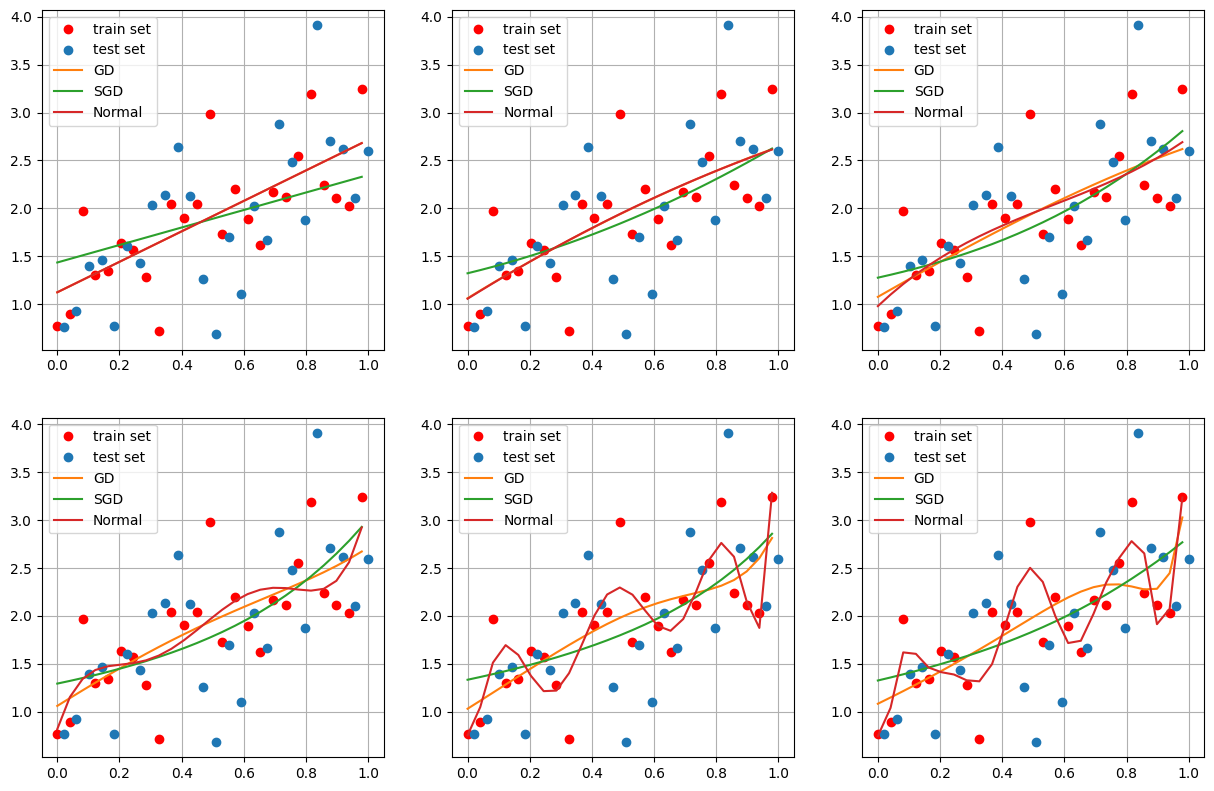

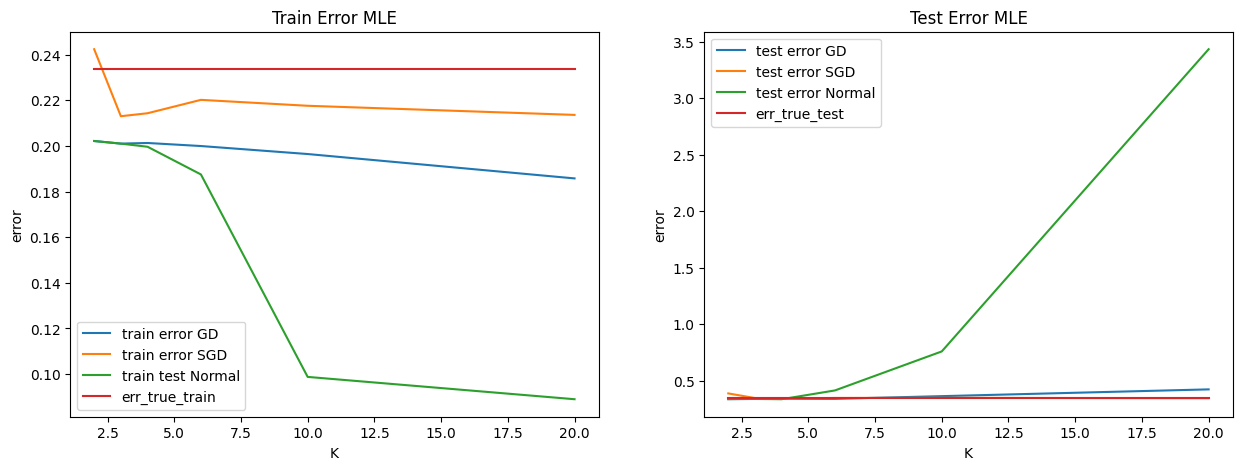

In [7]:
execMLE(3, 50, '')

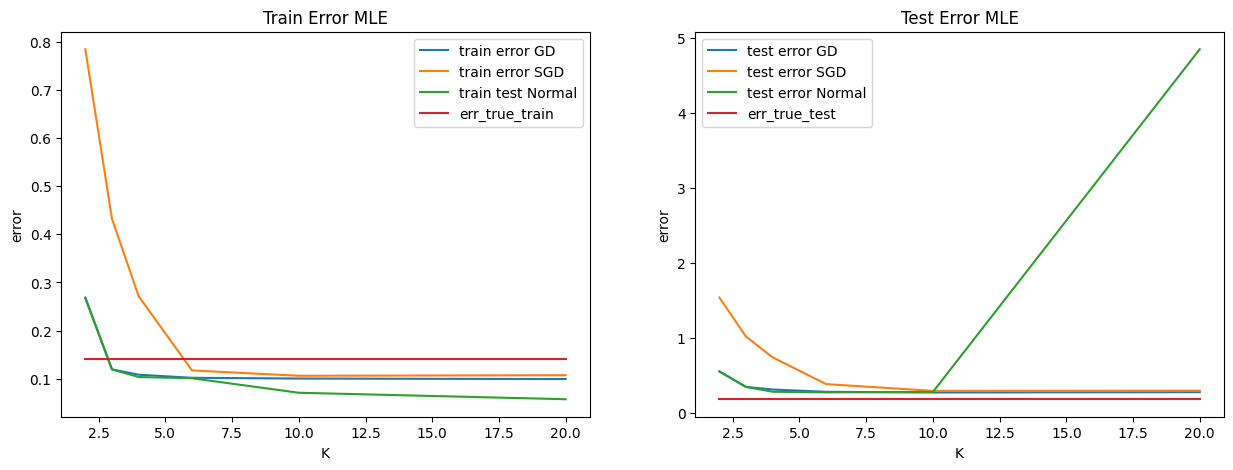

In [8]:
execMLE(6, 50)

In [9]:

def plotMAP(X_train, Y_train, X_test, Y_test, K, lmbda, i, true_sol, plot=None):
    Phi2 = vander(X_train, K)
    D = (X_train, Y_train)
    theta_mle_trial = callGD(D, K, 'MAP', lmbda)
    theta_mle_trial2 = np.linalg.solve(Phi2.T @ Phi2 + lmbda * np.eye(K), Phi2.T @ Y_train)
    theta_mle_trial3 = callSGD(D, K, 'MAP', lmbda)
    f_x_trail = Phi2 @ theta_mle_trial
    f_x_trail2 = Phi2 @ theta_mle_trial2
    f_x_trail3 = Phi2 @ theta_mle_trial3

    if plot is not None:
        plt.subplot(3,3,i)
        plt.plot(X_train, Y_train, 'ro')
        plt.plot(X_test, Y_test, 'o')
        plt.plot(X_train, f_x_trail)
        plt.plot(X_train, f_x_trail3)
        plt.plot(X_train, f_x_trail2)
        plt.legend(['train set', 'test set', 'GD', 'SGD', 'Normal'])
        plt.grid()
   

    return computeError(theta_mle_trial, (X_train, Y_train)), computeError(theta_mle_trial, (X_test, Y_test)),\
        computeError(theta_mle_trial2, (X_train, Y_train)), computeError(theta_mle_trial2, (X_test, Y_test)),\
            computeError(true_sol, (X_train, Y_train)), computeError(true_sol, (X_test, Y_test)),\
                computeError(theta_mle_trial3, (X_train, Y_train)), computeError(theta_mle_trial3, (X_test, Y_test)),


def execMAP(K, N, lmbda, plot=None):
    data = dataset[(N, K)]
    X_train = data[4]
    Y_train = data[5]
    X_test = data[6]
    Y_test = data[7]
    true_sol = data[2]

    train_err_GD = []
    test_err_GD = []
    train_err_Normal = []
    test_err_Normal = []
    err_true_train = []
    err_true_test = []
    train_err_SGD = []
    test_err_SGD = []

    if plot is not None:
        plt.figure(figsize=(15,15))
    for i in range(len(Ks)):
        e1, e2, e3, e4, e5, e6, e7, e8 = plotMAP(X_train, Y_train, X_test, Y_test, Ks[i], lmbda, i+1, true_sol, plot)
        train_err_GD.append(e1)
        test_err_GD.append(e2)
        train_err_Normal.append(e3)
        test_err_Normal.append(e4)
        err_true_train.append(e5)
        err_true_test.append(e6)
        train_err_SGD.append(e7)
        test_err_SGD.append(e8)
    if plot is not None:
        plt.show()

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(Ks, train_err_GD)
    plt.plot(Ks, train_err_SGD)
    plt.plot(Ks, train_err_Normal)
    plt.plot(Ks, err_true_train)
    plt.title("Train Error MAP")
    plt.ylabel('error')
    plt.xlabel('K')
    plt.legend(['train error GD', 'train error SGD', 'train test Normal', 'err_true_train'])
    
    plt.subplot(1,2,2)
    plt.plot(Ks, test_err_GD)
    plt.plot(Ks, test_err_SGD)
    plt.plot(Ks, test_err_Normal)
    plt.plot(Ks, err_true_test)
    plt.title("Test Error MAP")
    plt.ylabel('error')
    plt.xlabel('K')
    plt.legend(['test error GD', 'test error SGD', 'test error Normal', 'err_true_test'])
    plt.show()




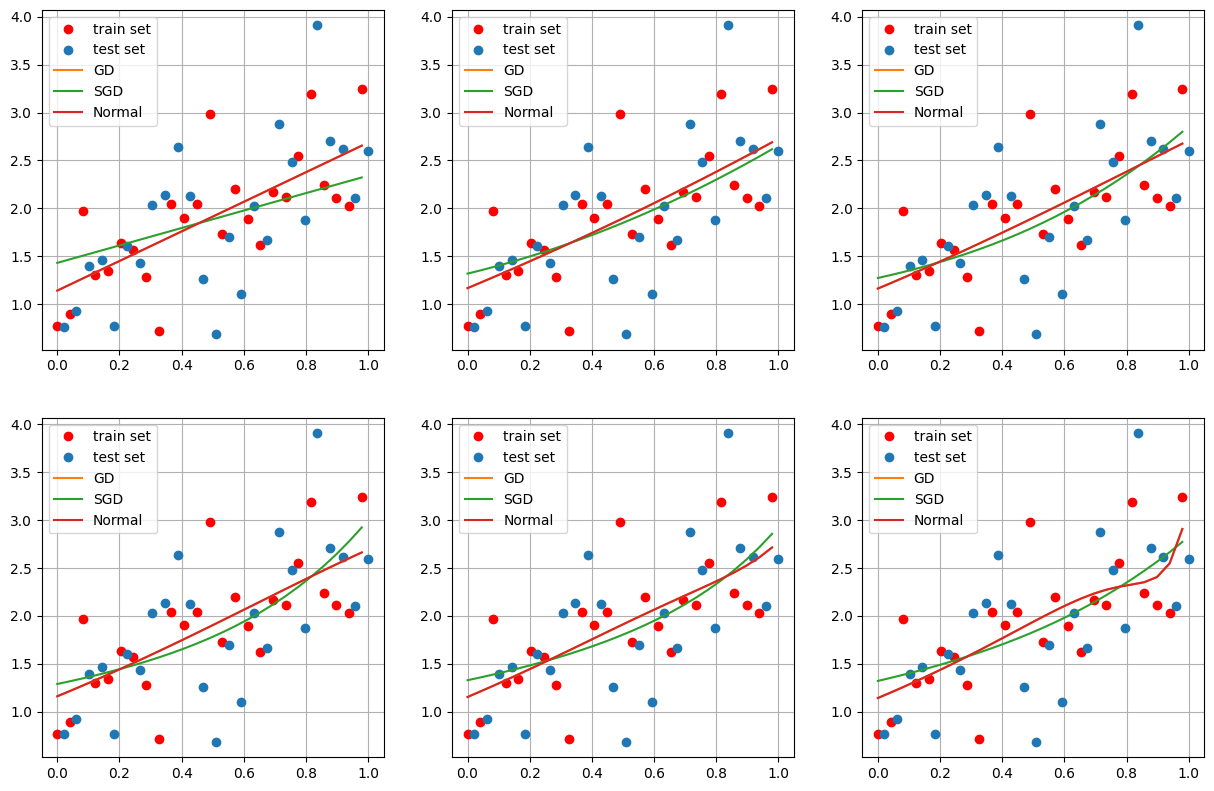

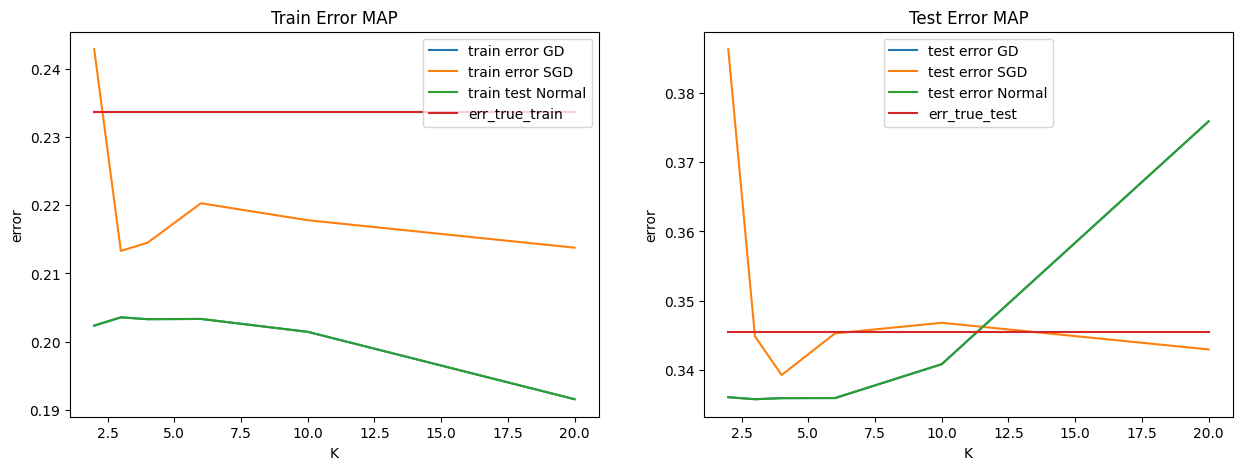

In [10]:
execMAP(3, 50, 0.1, '')

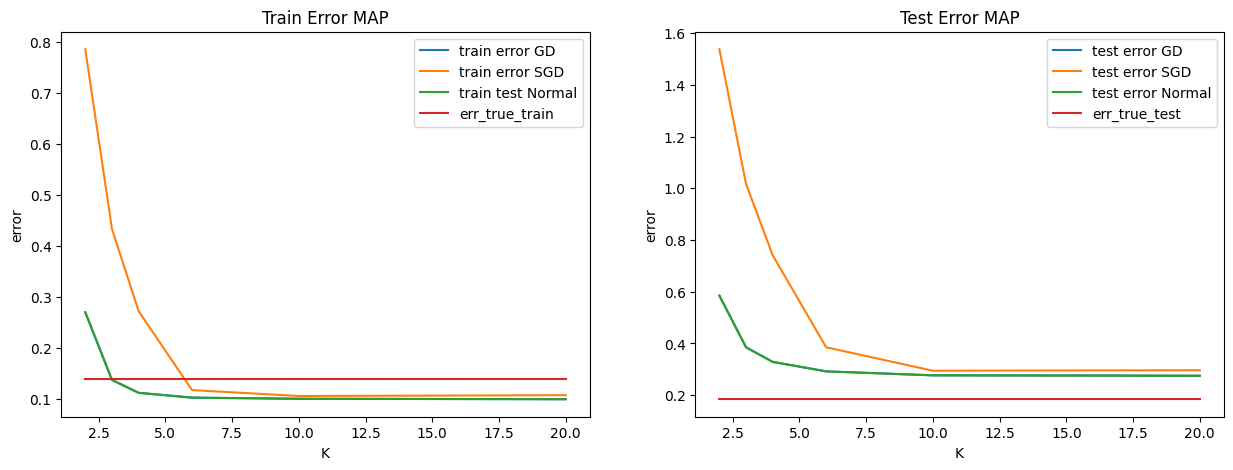

In [11]:
execMAP(6, 50, 0.1)

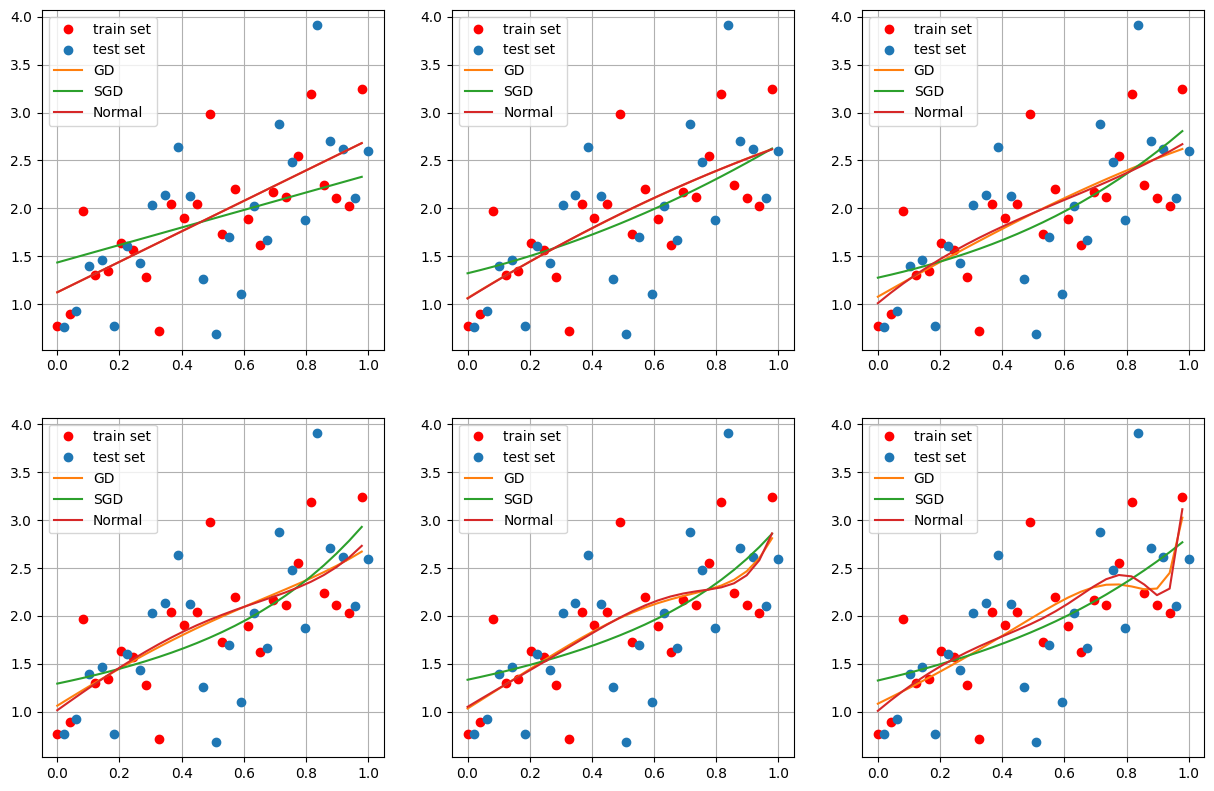

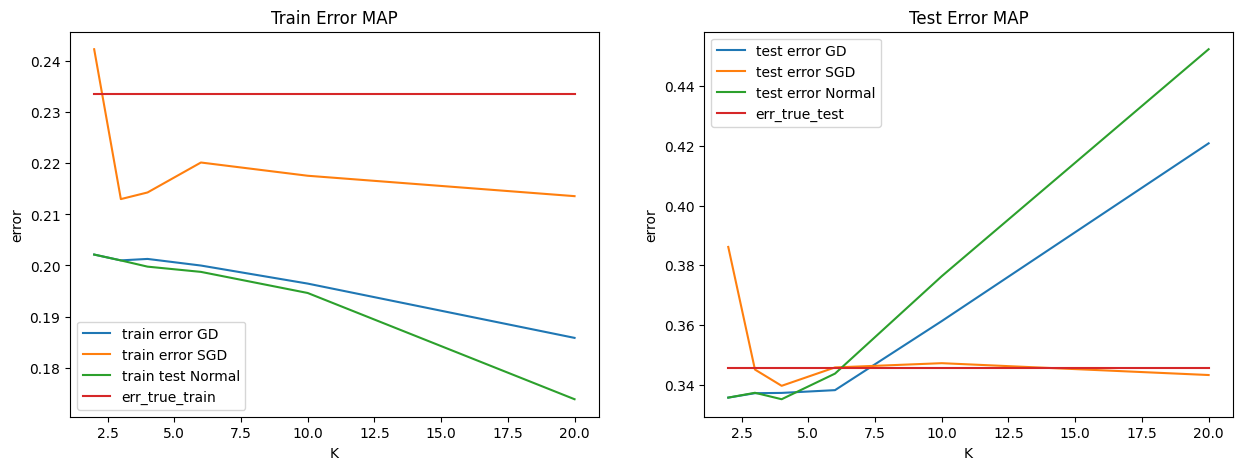

In [12]:
execMAP(3, 50, 0.001, '')

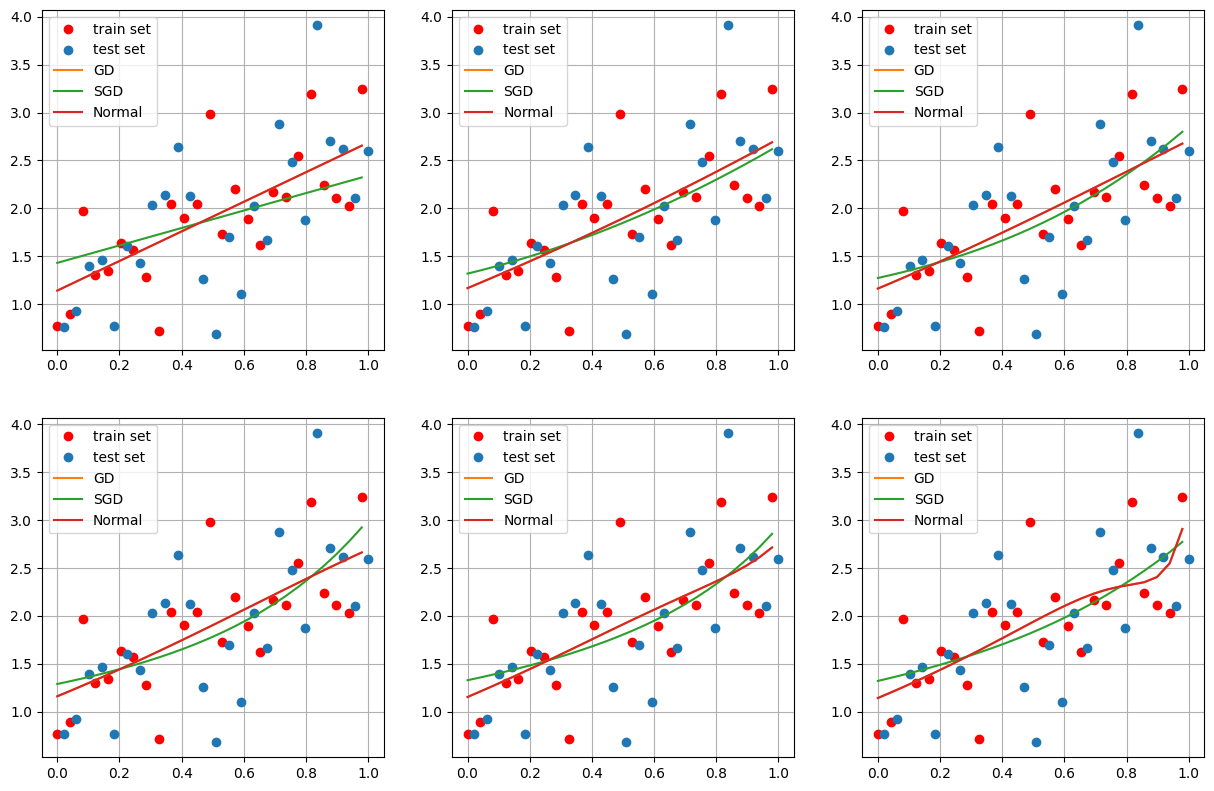

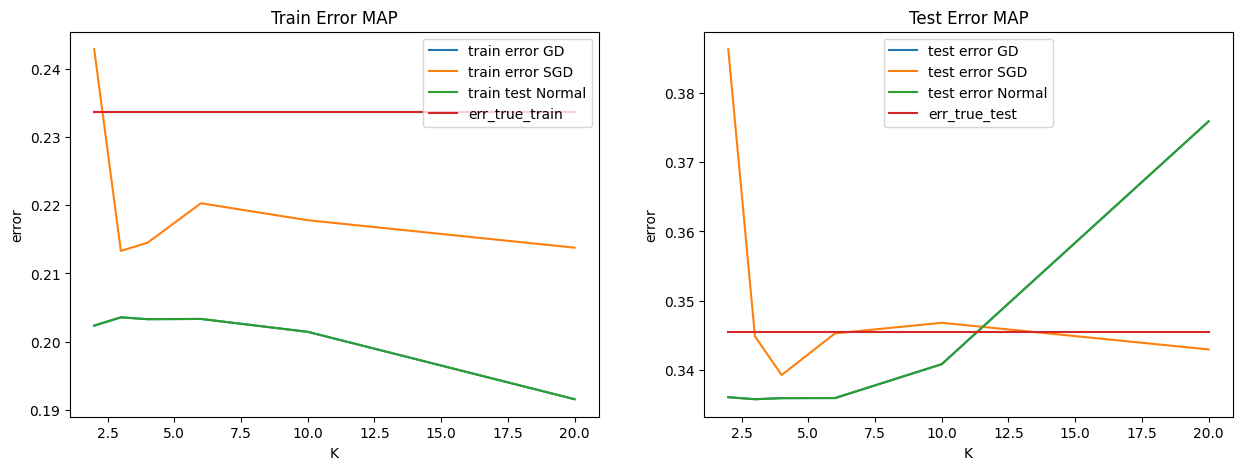

In [13]:
execMAP(3, 50, 0.1, '')

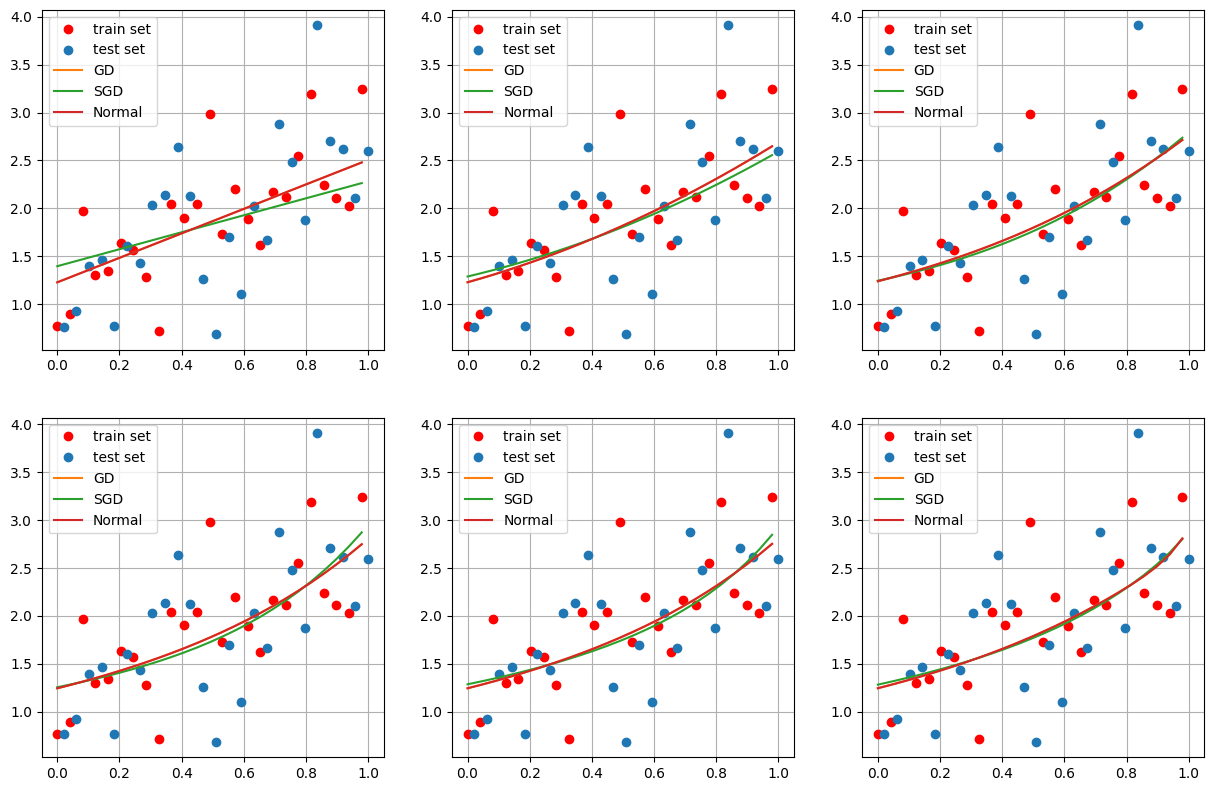

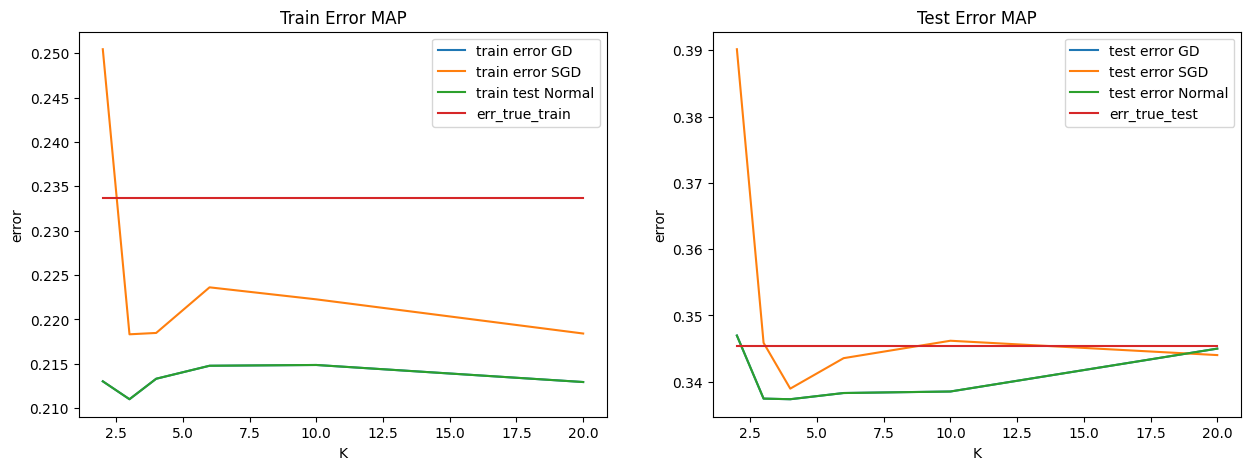

In [14]:
execMAP(3, 50, 1, '')

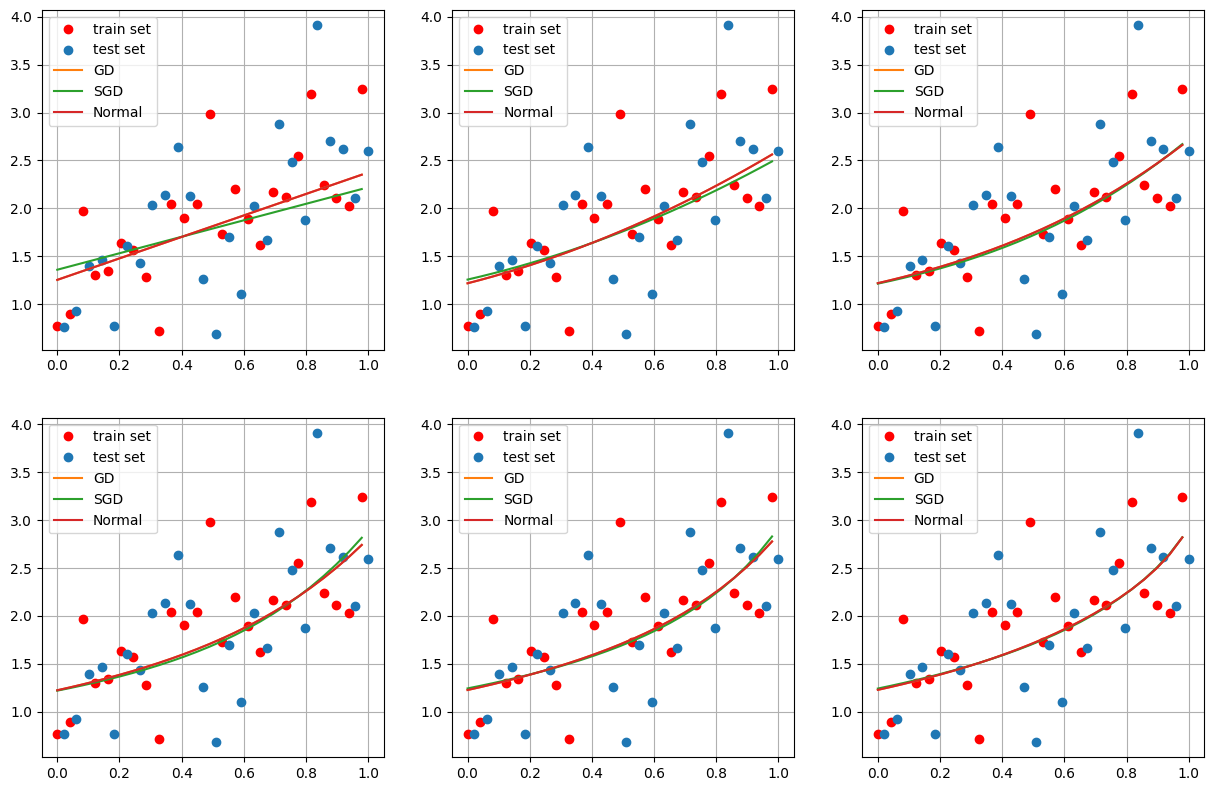

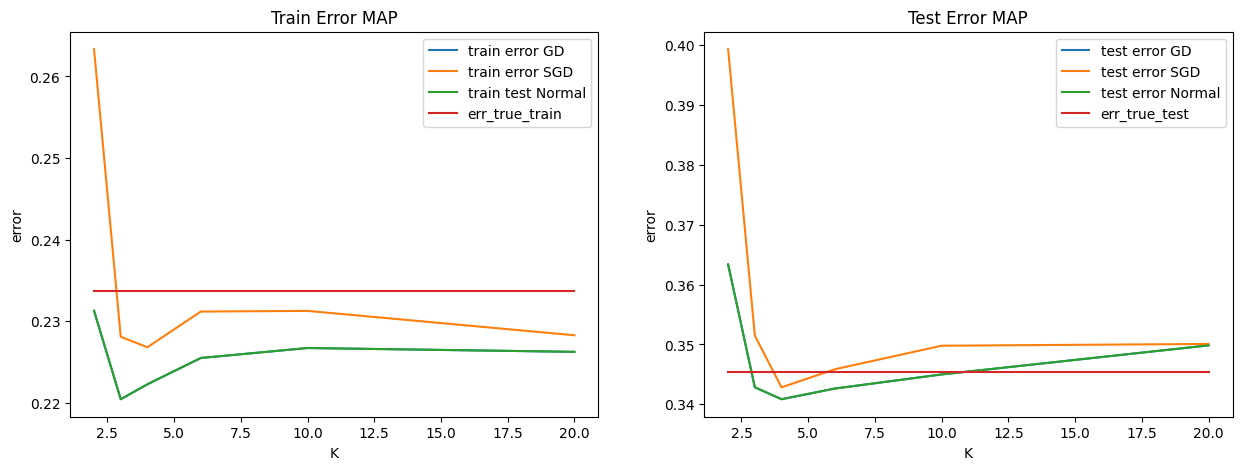

In [15]:
execMAP(3, 50, 2, '')